# SURFER v3.0 - GLODAP data processing

**Author** : Victor Couplet

**This notebook doesn't need to be run to use SURFER v3.0**

This notebook presents the code for :
- computing averaged vertical profiles from 3D GLODAP climatologies
- computing thermal expansion coefficients based on 3D GLODAP climatologies

To run this notebook, some data needs to be downloaded : 

1. Go to : https://www.ncei.noaa.gov/data/oceans/archive/arc0221/0286118/1.1/data/0-data/GLODAPv2.2016b_MappedClimatologies/
2. Download files :
   - GLODAPv2.2016b.PI_TCO2.nc
   - GLODAPv2.2016b.TCO2.nc
   - GLODAPv2.2016b.TAlk.nc
   - GLODAPv2.2016b.temperature.nc
   - GLODAPv2.2016b.salinity.nc
   - GLODAPv2.2016b.pHtsinsitutp.nc
3. Specify the directory where you downloaded those files on your machine :

In [10]:
path_GLODAP = '/example/path'

You are now ready to run this notebook !

## Python packages

In [1]:
import numpy as np
import os 
import xarray as xr
import tabulate

from math import floor,log10
from timeit import default_timer as timer
from numba import jit

from scipy.integrate import solve_ivp, odeint
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


## Functions for solving the carbonate sytem

In [7]:
# Gaz constant
R = 83.14462 # bar*cm3/mol*K

# Solubility and dissociation constants with temperature and pressure (depth) dependence

@jit
def k0(T,S) :
     return np.exp(-60.2409+93.4517*(100/T)+23.3585*np.log(T/100)+S*(0.023517-0.023656*(T/100)+0.0047036*(T/100)**2))

@jit
def k1_p(T,S,z) : 
    TC = T-273.15
    mlog10k1 = -62.008+3670.7/T+9.7944*np.log(T)-0.0118*S+0.000116*S**2
    k1_0 = 10**-mlog10k1
    dV = -25.5 + 0.1271*TC
    dK = (-3.08 + 0.0877*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return k1_0*np.exp(C)

@jit
def k2_p(T,S,z) : 
    TC = T-273.15
    mlog10k2 = 4.777+1394.7/T-0.0184*S+0.000118*S**2
    k2_0 = 10**-mlog10k2
    dV = -15.82 - 0.0219*TC
    dK = (1.13 - 0.1475*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return k2_0*np.exp(C)

@jit
def kW_p(T,S,z) : 
    TC = T-273.15
    lnkW = 148.96502 - 13847.26/T - 23.6521*np.log(T)+ S**0.5*(-5.977 + 118.67/T + 1.0495*np.log(T))-0.01615*S
    kW_0 = np.exp(lnkW)
    dV = -25.60 + 0.2324*TC - 0.0036246*TC**2
    dK = (-5.13 + 0.0794*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return kW_0*np.exp(C)

@jit
def kB_p(T,S,z) : 
    TC = T-273.15
    lnkB = 1/T*(-8966.9-2890.53*S**0.5-77.942*S + 1.728*S**1.5-0.0996*S**2)+148.0248+137.1942*S**0.5+1.62142*S+0.053105*S**0.5*T+np.log(T)*(-24.4344-25.085*S**0.5-0.2474*S)
    kB_0 = np.exp(lnkB)
    dV = -29.48 + 0.1622*TC - 0.002608*TC**2
    dK = (-2.84)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return kB_0*np.exp(C)

# Function to compute [H^+] (in mol/kg) from DIC and alkalinity , with dependence on T,S and pressure (depth)
@jit
def h(TCO2,TAlk,T,S,z) :
    
    c= 11.88*10**-6 # conversion from µmol/kg to mol/kg
    
    DIC = TCO2*10**-6 # conversion from µmol/kg to mol/kg
    alk = TAlk*10**-6 # conversion from µmol/kg to mol/kg
    
    K1 = k1_p(T,S,z) # constants in mol/kg or similar
    K2 = k2_p(T,S,z)
    KB = kB_p(T,S,z)
    KW = kW_p(T,S,z)
    
    q0 = - K1*K2*KB*KW
    q1 = (alk-2*DIC-c*S)*K1*K2*KB - K1*K2*KW - K1*KB*KW
    q2 = (alk-2*DIC+KB)*K1*K2 + (alk-DIC-c*S)*K1*KB-K1*KW-KB*KW
    q3 = (alk-DIC+KB)*K1+(alk-c*S)*KB+K1*K2-KW
    q4 = alk + K1 + KB

    cc2 = KB*(1-c*S/alk)+K1*(1-DIC/alk)
    cc1 = K1*(KB*(1-c*S/alk-DIC/alk)+K2*(1-2*DIC/alk))
    cc0 = K1*K2*KB*(1-(2*DIC+c*S)/alk)

    if alk < 0 :
        h0 = 0.001
    elif alk >= 2*DIC+c*S :
        h0 = 10**-10
    else :
        if cc2*cc2-3*cc1 < 0 :
            h0 = 10**-7
        else : 
            sqroot = np.sqrt(cc2*cc2-3*cc1)
            hmin = (-cc2+sqroot)/3
            h0 = hmin +np.sqrt(-(hmin**3+cc2*hmin**2+cc1*hmin+cc0)/sqroot)
    y0 = h0

    for i in range(0,5) :
        y = y0 - (((((y0+q4)*y0+q3)*y0+q2)*y0+q1)*y0 + q0)/((((5*y0+4*q4)*y0+3*q3)*y0+2*q2)*y0 + q1)
        y0 =y

    return y0

## Computation of vertical profiles of ocean biogeochemical variables from GLODAP climatologies

In [11]:
x1=np.linspace(20.5,379.5,360)
x2=np.linspace(-89.5,89.5,180)
X1,X2 = np.meshgrid(x2,x1)
# We give a weight to each 1° x 1° cell based on its area (depends on latitude)
area_weight = np.cos(X1.T*np.pi/180)*np.sin(0.5*np.pi/180)*np.pi/180/(2*np.pi)
DEPTH = np.array([   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,
        200.,  250.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000., 1100., 1200., 1300., 1400., 1500., 1750., 2000., 2500.,
       3000., 3500., 4000., 4500., 5000., 5500.])

# Function to compute the vertical profiles
def vertical_profile_from3Dclimatology(variable) : 

    # Open the dataset
    file_name = f'GLODAPv2.2016b.{variable}.nc'
    ds = xr.open_dataset(os.path.join(path_GLODAP,file_name))
    
    # Initialize arrays
    dp = np.zeros(33)
    dp_wa = np.zeros(33)
    dp_areas = np.zeros(33)
    
    for i in range(0,33):
        # Compute the mean value at each level (not used further in this function)
        dp[i] = np.mean(ds[variable][i])
        
        # Calculate the ocean area where data is not NaN
        ocean_area = np.sum(np.multiply(np.where(np.isnan(ds[variable][i]), 0, 1), area_weight))
        dp_areas[i] = ocean_area
        
        # Adjust cell weights to normalize by the total ocean area
        new_cell_weights = area_weight / ocean_area
        
        # Compute the area-weighted average
        dp_wa[i] = np.sum(np.multiply(ds[variable][i, :, :], new_cell_weights))

    return dp,dp_wa,dp_areas
    

In [12]:
variables_list = ['PI_TCO2','TCO2','TAlk','temperature','salinity','pHtsinsitutp']

depth_profiles = np.zeros((len(variables_list),33))
weighted_depth_profiles = np.zeros((len(variables_list),33))
areas_depth_profiles = np.zeros((len(variables_list),33))

# Computation of the vertical profiles
for i in range(0,len(variables_list)) :
    depth_profiles[i], weighted_depth_profiles[i], areas_depth_profiles[i] = vertical_profile_from3Dclimatology(variables_list[i])

We now compute climatologies for species of the carbonate system ($H^+$, $H_2CO_3^*$,   $HCO_3^-$, $CO_3^{2-}$) based on the climatologies for DIC, Alk, Temperature, and salinity.

In [15]:
TAlk_GLODAP = xr.open_dataset(os.path.join(path_GLODAP,'GLODAPv2.2016b.TAlk.nc'))   
TCO2_GLODAP = xr.open_dataset(os.path.join(path_GLODAP,'GLODAPv2.2016b.TCO2.nc'))
temperature_GLODAP = xr.open_dataset(os.path.join(path_GLODAP,'GLODAPv2.2016b.temperature.nc'))
salinity_GLODAP = xr.open_dataset(os.path.join(path_GLODAP,'GLODAPv2.2016b.salinity.nc'))
pH_GLODAP = xr.open_dataset(os.path.join(path_GLODAP,'GLODAPv2.2016b.pHtsinsitutp.nc'))

pH_computed_from_GLODAP = np.empty((33,180,360))
CO3_computed_from_GLODAP = np.empty((33,180,360))
HCO3_computed_from_GLODAP = np.empty((33,180,360))
H2CO3_computed_from_GLODAP = np.empty((33,180,360))

pH_computed_from_GLODAP[:] = np.nan
CO3_computed_from_GLODAP[:] = np.nan
HCO3_computed_from_GLODAP[:] = np.nan
H2CO3_computed_from_GLODAP[:] = np.nan

The following cell may take some time to execute (~ 5min) 

In [16]:
for i in range(0,33) :
    
    z = int(DEPTH[i])
    
    for j in range(0,180) :
        for k in range(0,360):
            
            T = temperature_GLODAP.temperature.values[i,j,k]+273.15
            S = salinity_GLODAP.salinity.values[i,j,k]
            Talk = TAlk_GLODAP.TAlk.values[i,j,k]
            DIC = TCO2_GLODAP.TCO2.values[i,j,k]
            pH_0 = pH_GLODAP.pHtsinsitutp.values[i,j,k]
            
            # if one of the values in GLODAP is NaN, we don't perform thze computation and continue to next iteration
            if  np.isnan(T+S+Talk+DIC) == True :
                continue  

            K0 = k0(T,S)
            K1 = k1_p(T,S,z)
            K2 = k2_p(T,S,z)

            H = h(DIC,Talk,T,S,z)
      
            CO3 = DIC/(H/K2+H**2/(K1*K2)+1)
            HCO3 = H*CO3/K2
            H2CO3 = DIC - HCO3 - CO3

            pH_computed_from_GLODAP[i,j,k] = -np.log10(H)
            CO3_computed_from_GLODAP[i,j,k] = CO3
            HCO3_computed_from_GLODAP[i,j,k] = HCO3
            H2CO3_computed_from_GLODAP[i,j,k] = H2CO3

    print(f'\r{(i+1)/33*100:.2f}% completed', end='')   


100.00% completed

In [17]:
# Function to compute the vertical profiles of our computed climatologies
def vertical_profile_from_computed_3Dclimatology(variable) : 
    
    # Initialize arrays
    dp = np.zeros(33)
    dp_wa = np.zeros(33)
    dp_areas = np.zeros(33)
    
    for i in range(0,33):
        # Compute the mean value at each level (not used further in this function)
        dp[i] = np.nanmean(variable[i])
        
        # Calculate the ocean area where data is not NaN
        ocean_area = np.sum(np.multiply(np.where(np.isnan(variable[i]), 0, 1), area_weight))
        dp_areas[i] = ocean_area
        
        # Adjust cell weights to normalize by the total ocean area
        new_cell_weights = area_weight / ocean_area
        
        # Compute the area-weighted average
        dp_wa[i] = np.nansum(np.multiply(variable[i, :, :], new_cell_weights))

    return dp,dp_wa,dp_areas


In [18]:
computed_variables_list = [pH_computed_from_GLODAP,CO3_computed_from_GLODAP,HCO3_computed_from_GLODAP,H2CO3_computed_from_GLODAP]

depth_profiles_add = np.zeros((len(computed_variables_list),33))
weighted_depth_profiles_add =  np.zeros((len(computed_variables_list),33))
areas_depth_profiles_add =  np.zeros((len(computed_variables_list),33))

# Computation of the vertical profiles of our computed climatologies
for i in range(0,len(computed_variables_list)) :
    depth_profiles_add[i], weighted_depth_profiles_add[i], areas_depth_profiles_add[i] = vertical_profile_from_computed_3Dclimatology(computed_variables_list[i])

In [19]:
# Depths of SURFER v3.0 ocean layers 
hu = 150
hi = 500
hd = 3150

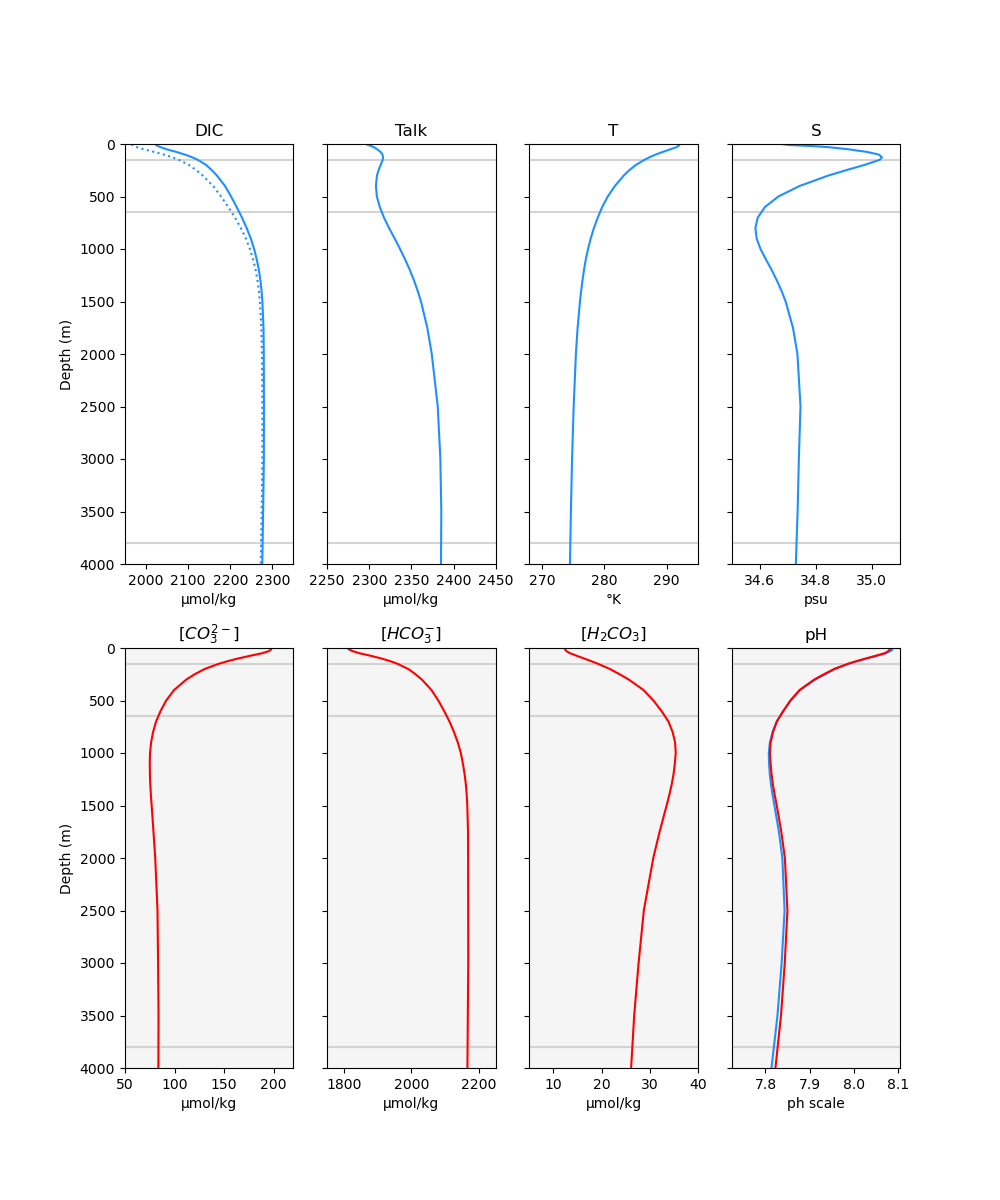

In [20]:
## Figure 

fig,[[ax1,ax2,ax3,ax4],[ax6,ax7,ax8,ax5]] =plt.subplots(2,4,figsize=(10,12),sharey = True)

ax1.set_ylim((4000,0))

for axes in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8] :
    axes.axhline(0,0,1,c='lightgray')
    axes.axhline(hu,0,1,c='lightgray')
    axes.axhline(hu+hi,0,1,c='lightgray')
    axes.axhline(hu+hi+hd,0,1,c='lightgray')
    
kwargs = {'linestyle':'-', 'color':'dodgerblue'}

ax1.plot(weighted_depth_profiles[1], DEPTH,**kwargs)
ax1.plot(weighted_depth_profiles[0], DEPTH,color='dodgerblue',ls=':')
ax2.plot(weighted_depth_profiles[2], DEPTH,**kwargs)
ax3.plot(weighted_depth_profiles[3]+273.15, DEPTH,**kwargs)
ax4.plot(weighted_depth_profiles[4], DEPTH,**kwargs)
ax5.plot(weighted_depth_profiles[5], DEPTH,**kwargs)

kwargs2 = {'linestyle':'-', 'color':'r'}

ax5.plot(weighted_depth_profiles_add[0], DEPTH,**kwargs2)
ax6.plot(weighted_depth_profiles_add[1], DEPTH,**kwargs2)
ax7.plot(weighted_depth_profiles_add[2], DEPTH,**kwargs2)
ax8.plot(weighted_depth_profiles_add[3], DEPTH,**kwargs2)

## Plot characteristics

ax1.set_title('DIC')
ax2.set_title('Talk')
ax3.set_title('T')
ax4.set_title('S')
ax5.set_title('pH')
ax6.set_title(r'$[CO_3^{2-}]$')
ax7.set_title(r'$[HCO_3^{-}]$')
ax8.set_title(r'$[H_2CO_3]$')

ax1.set_xlim((1950,2350))
ax2.set_xlim((2250,2450))
ax3.set_xlim((268,295))
ax4.set_xlim((34.5,35.1))
# ax5.set_xlim((7.7,8.25))
ax6.set_xlim((50,220))
ax7.set_xlim((1750,2250))
ax8.set_xlim((5,40))

ax1.set_xlabel('µmol/kg')
ax2.set_xlabel('µmol/kg')
ax3.set_xlabel('°K')
ax4.set_xlabel('psu')
ax5.set_xlabel('ph scale')
ax6.set_xlabel('µmol/kg')
ax7.set_xlabel('µmol/kg')
ax8.set_xlabel('µmol/kg')

ax1.set_ylabel('Depth (m)')
ax6.set_ylabel('Depth (m)')

ax5.set_facecolor('whitesmoke')
ax6.set_facecolor('whitesmoke')
ax7.set_facecolor('whitesmoke')
ax8.set_facecolor('whitesmoke')


In blue : The horizontally averaged depth profiles of the GLODAP climatologies.

In red : The horizontally averaged depth profiles of the climatologies for the carbonate species compued based on the GLODAP climatologies for DIC, Alk,T and S. 

The pH profile we comptuted is very close to the vertical profile computed based on the GLODAP pH data. This gives credibility to our pH (or H) computation scheme. Small differences are probably due to our approximation of total alkalinity as carbonate, borate and water self ionisation alkalinity : $$ \mathrm{Alk} \approx \mathrm{Alk}_{CBW}  =\left[\mathrm{HCO}_3^{-}\right]+2\left[\mathrm{CO}_3^{2-}\right]+\left[\mathrm{OH}^{-}\right]-\left[\mathrm{H}^{+}\right]+\left[\mathrm{B}(\mathrm{OH})_4^{-}\right]$$

## Initial conditions for SURFER v3.0

We can further average the obtaine vertical profiles in SURFER v3.0 oceanic layers to obtain intitial conditions for the model, as well as a calibration point.

In [23]:
depthsU = np.linspace(0,hu-1,hu)
depthsI= np.linspace(hu,hu+hi-1,hi)
depthsD = np.linspace(hu+hi,hu+hi+hd-1,hd)

depths10 = np.linspace(0,10,11)


var_means = np.zeros((6,4))

for i in range(0,6) : 
    
    var_inter = interpolate.interp1d(DEPTH,weighted_depth_profiles[i],bounds_error= True)
    var_area_inter = interpolate.interp1d(DEPTH,areas_depth_profiles[i],bounds_error= True)

    var_means[i,0] = np.sum(np.multiply(var_inter(depthsU),var_area_inter(depthsU)))/np.sum(var_area_inter(depthsU))
    var_means[i,1] = np.sum(np.multiply(var_inter(depthsI),var_area_inter(depthsI)))/np.sum(var_area_inter(depthsI))
    var_means[i,2] = np.sum(np.multiply(var_inter(depthsD),var_area_inter(depthsD)))/np.sum(var_area_inter(depthsD))
    var_means[i,3] = np.sum(np.multiply(var_inter(depths10),var_area_inter(depths10)))/np.sum(var_area_inter(depths10))
    
line_headers = variables_list = [['PI_TCO2'],['TCO2'],['TAlk'],['temperature'],['salinity'],['pHtsinsitutp']]

data_table = np.hstack((line_headers, var_means))

table = tabulate.tabulate(data_table, headers = ['U','I','D','10m'],tablefmt='html',floatfmt = '.4f')
table

,U,I,D,10m
PI_TCO2,2017.6546,2152.6228,2266.5701,1966.6388
TCO2,2069.4982,2182.0898,2272.3865,2022.5362
TAlk,2310.6063,2310.6017,2367.2144,2297.6035
temperature,16.3436,8.9475,2.6483,18.9120
salinity,34.9338,34.7730,34.7019,34.6923
pHtsinsitutp,8.0478,7.8909,7.8282,8.0864


In [24]:
var_means = np.zeros((4,4))

for i in range(0,4) : 
    
    var_inter = interpolate.interp1d(DEPTH,weighted_depth_profiles_add[i],bounds_error= True)
    var_area_inter = interpolate.interp1d(DEPTH,areas_depth_profiles_add[i],bounds_error= True)

    var_means[i,0] = np.sum(np.multiply(var_inter(depthsU),var_area_inter(depthsU)))/np.sum(var_area_inter(depthsU))
    var_means[i,1] = np.sum(np.multiply(var_inter(depthsI),var_area_inter(depthsI)))/np.sum(var_area_inter(depthsI))
    var_means[i,2] = np.sum(np.multiply(var_inter(depthsD),var_area_inter(depthsD)))/np.sum(var_area_inter(depthsD))
    var_means[i,3] = np.sum(np.multiply(var_inter(depths10),var_area_inter(depths10)))/np.sum(var_area_inter(depths10))
    
line_headers = variables_list = [['pH'],['CO3'],['HCO3'],['H2CO3']]

data_table = np.hstack((line_headers, var_means))

table = tabulate.tabulate(data_table, headers = ['U','I','D','10m'],tablefmt='html',floatfmt = '.4f')
table

,U,I,D,10m
pH,8.0446,7.8895,7.8337,8.0817
CO3,175.3994,104.5987,80.3469,197.6594
HCO3,1878.6790,2049.9349,2161.4486,1812.2544
H2CO3,15.0965,27.7274,30.7867,12.3979


For each climatology (original or computed), we plot the total horizontal area (normalized by Earth surface area) where we have data as a function of depth. This gives a depth profile of the ocean. Small differences between the different climatologies arise form missing data points. This could inroduce small errors/uncertainties in our computations, but these are not significant for the use we make of the data.

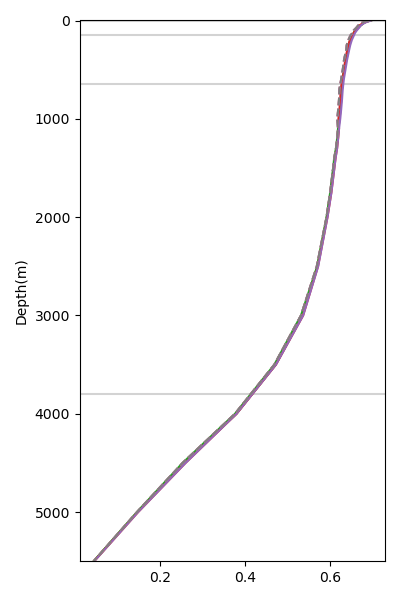

In [25]:
fig, ax = plt.subplots(1,1,figsize=(4,6))

ax.axhline(0,0,1,c='lightgray')
ax.axhline(hu,0,1,c='lightgray')
ax.axhline(hu+hi,0,1,c='lightgray')
ax.axhline(hu+hi+hd,0,1,c='lightgray')

for i in range(0,5):
    ax.plot(areas_depth_profiles[i], DEPTH)

for i in range(0,3):
    ax.plot(areas_depth_profiles_add[i], DEPTH,ls='--')
    


ax.set_ylim((5500,0))

ax.set_ylabel('Depth(m)')
plt.tight_layout()

We can save the vertical profiles data in csv files in order to reuse them. To do that, first specify a path to a directory where you want them saved :  
- To specify a custom directory, uncomment line under #custom directory . 
- To overwrite the `GLODAP_averaged_data.csv` and `GLODAP_computed_data.csv` in the `SURFER_v3` repository, uncomment lines under #overwrite and indicate the path to where you have downloaded the `SURFER_v3` repository on ypour machine.

In [28]:
#custom directory
# path_GLODAP_save = '/custom/path'

#overwrite 
# base_path = '/base/path/for/SURFER_v3'
# path_GLODAP_save = os.path.join(base_path, 'SURFER_v3/data/')

Then you can proceed with saving the data by running the following cell : 

In [29]:
# only save vertical profiles ! 

GLODAP_data = np.vstack((DEPTH,weighted_depth_profiles))
np.savetxt(os.path.join(path_GLODAP_save, 'GLODAP_averaged_data.csv'), GLODAP_data, delimiter=",")

GLODAP_computed_data = np.vstack((DEPTH,weighted_depth_profiles_add))
np.savetxt(os.path.join(path_GLODAP_save, 'GLODAP_computed_data.csv'), GLODAP_computed_data, delimiter=",")


## Computation of thermal expansion coefficients

TO obtain thermal expansion coefficients for our ocean layers, we first computed the thermal expansion coefficient at each ocean point based on the GLODAP climatologies. To do this, we use the International Thermodynamic Equation Of Seawater - 2010 (TEOS-10) and the Python implementation of the GSW Oceanographic toolbox of TEOS-10 (McDougall and Barker, 2011). This may involve downloadind the `gsw` package. 

In [30]:
import gsw

In [35]:
ds_T = xr.open_dataset(os.path.join(path_GLODAP,'GLODAPv2.2016b.temperature.nc'))
ds_SP = xr.open_dataset(os.path.join(path_GLODAP,'GLODAPv2.2016b.salinity.nc'))

alpha_dp_wa = np.zeros(33)
alpha_dp_areas = np.zeros(33)
for i in range(0,33) : 
    z = ds_SP.Depth[i]
    p = z*9.81*1026/10000
    SA = gsw.conversions.SA_from_SP(ds_SP.salinity[i], p, ds_SP.lon, ds_SP.lat)
    CT = gsw.conversions.CT_from_t(SA, ds_T.temperature[i], p)
    alpha = gsw.density.alpha(SA, CT, p)
  
    ocean_area = np.sum(np.multiply(np.where(np.isnan(alpha), 0, 1),area_weight))
    alpha_dp_areas[i] = ocean_area                    
    new_cell_weights = area_weight/ocean_area
    alpha_dp_wa[i] = np.sum(np.multiply(alpha,new_cell_weights))
    
DEPTH = ds_SP.Depth.load()

We then average over each of SURFER v3.0 oceanic layers.

In [36]:
depthsU = np.linspace(0,hu-1,hu)
depthsI= np.linspace(hu,hu+hi-1,hi)
depthsD = np.linspace(hu+hi,hu+hi+hd-1,hd)
depths10 = np.linspace(0,5500,5001)

var_means = np.zeros((1,4))

var_inter = interpolate.interp1d(DEPTH,alpha_dp_wa*10**4,bounds_error= True)
var_area_inter = interpolate.interp1d(DEPTH,alpha_dp_areas,bounds_error= True)

var_means[0,0] = np.sum(np.multiply(var_inter(depthsU),var_area_inter(depthsU)))/np.sum(var_area_inter(depthsU))
var_means[0,1] = np.sum(np.multiply(var_inter(depthsI),var_area_inter(depthsI)))/np.sum(var_area_inter(depthsI))
var_means[0,2] = np.sum(np.multiply(var_inter(depthsD),var_area_inter(depthsD)))/np.sum(var_area_inter(depthsD))
var_means[0,3] = np.sum(np.multiply(var_inter(depths10),var_area_inter(depths10)))/np.sum(var_area_inter(depths10))

line_headers = [[r'$\alpha \times 10^4$']]
data_table = np.hstack((line_headers, var_means))

table = tabulate.tabulate(data_table, headers = ['U','I','D','10m'],tablefmt='html',floatfmt = '.4f')
table

,U,I,D,10m
$\alpha \times 10^4$,2.1965,1.6097,1.3895,1.5092


We can plot the obtained vertical profiletogether with the values we use for SURFER's ocean layers :

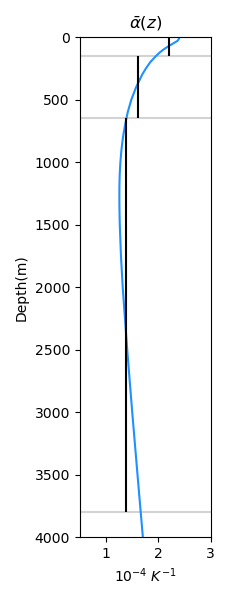

In [37]:
fig, ax = plt.subplots(1,1,figsize=(2.3,6))

alpha_U = 2.1965
alpha_I = 1.6097
alpha_D = 1.3895

ax.axhline(0,0,1,c='lightgray')
ax.axhline(hu,0,1,c='lightgray')
ax.axhline(hu+hi,0,1,c='lightgray')
ax.axhline(hu+hi+hd,0,1,c='lightgray')
    
ax.plot(alpha_dp_wa*10**4, DEPTH, c='dodgerblue')
ax.set_ylim((4000,0))
ax.set_xlim((0.5,3))


kwargs={'linestyle':'-', 'color':'k'}

ax.vlines(alpha_U,0,hu,**kwargs)
ax.vlines(alpha_I,hu,hu+hi,**kwargs)
ax.vlines(alpha_D,hu+hi,hu+hi+hd,**kwargs)

ax.set_title(r'$\bar{\alpha}(z)$')
ax.set_xlabel(r'$10^{-4}$ $K^{-1}$')
ax.set_ylabel('Depth(m)')
plt.tight_layout()